In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer

# === Load data ===
train = pd.read_csv("/kaggle/input/preprocessing-2/train_processed.csv")
test  = pd.read_csv("/kaggle/input/preprocessing-2/test_processed.csv")

In [2]:
TARGET = "HotelValue"
features = [c for c in train.columns if c not in [TARGET, "Id"]]

X = train[features].copy()
y = train[TARGET].copy()

# === Train/validation split ===
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Identify numeric and categorical columns ===
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

In [3]:
# === Identify skewed numeric columns ===
skew_values = X_train[num_cols].skew().sort_values(ascending=False)
skewed_cols = skew_values[abs(skew_values) > 0.75].index.tolist()
non_skewed_cols = [c for c in num_cols if c not in skewed_cols]

print(f"Skewed columns ({len(skewed_cols)}): {skewed_cols}")
print(f"Non-skewed columns ({len(non_skewed_cols)}): {non_skewed_cols}")

Skewed columns (23): ['ExtraFacilityValue', 'SwimmingPoolArea', 'LandArea', 'LowQualityArea', 'SeasonalPorchArea', 'Kitchens', 'BasementFacilitySF2', 'BasementHalfBaths', 'ScreenPorchArea', 'EnclosedVerandaArea', 'RoadAccessLength', 'BasementFacilitySF1', 'OpenVerandaArea', 'BasementTotalSF', 'TerraceArea', 'UsableArea', 'GroundFloorArea', 'PropertyClass', 'FacadeArea', 'BasementUnfinishedSF', 'UpperFloorArea', 'OverallCondition', 'ParkingConstructionYear']
Non-skewed columns (13): ['OverallQuality', 'ConstructionYear', 'RenovationYear', 'BasementFullBaths', 'FullBaths', 'HalfBaths', 'GuestRooms', 'TotalRooms', 'Lounges', 'ParkingCapacity', 'ParkingArea', 'MonthSold', 'YearSold']


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


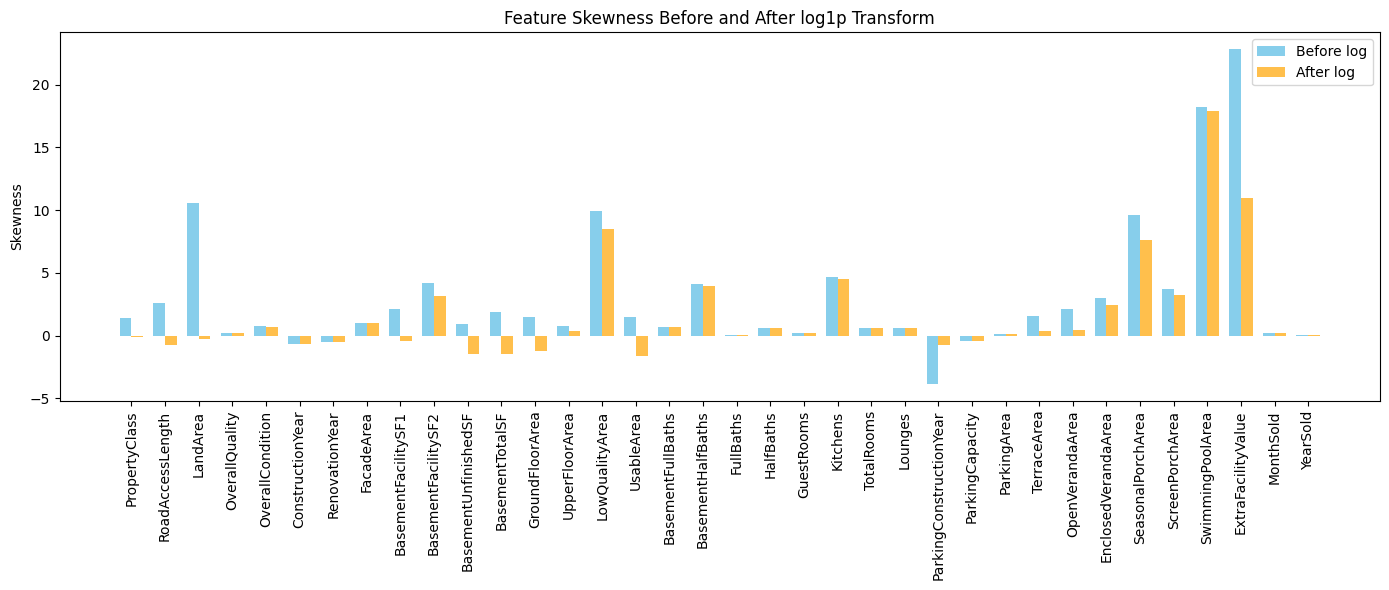

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


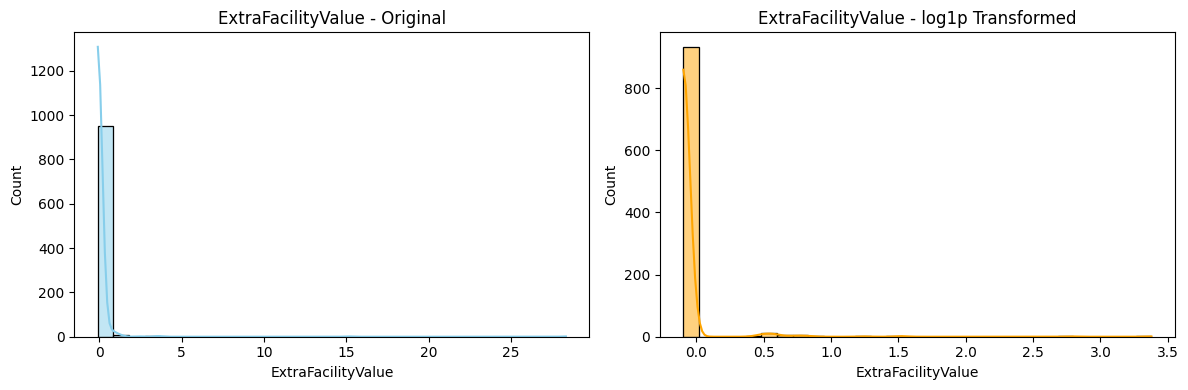

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


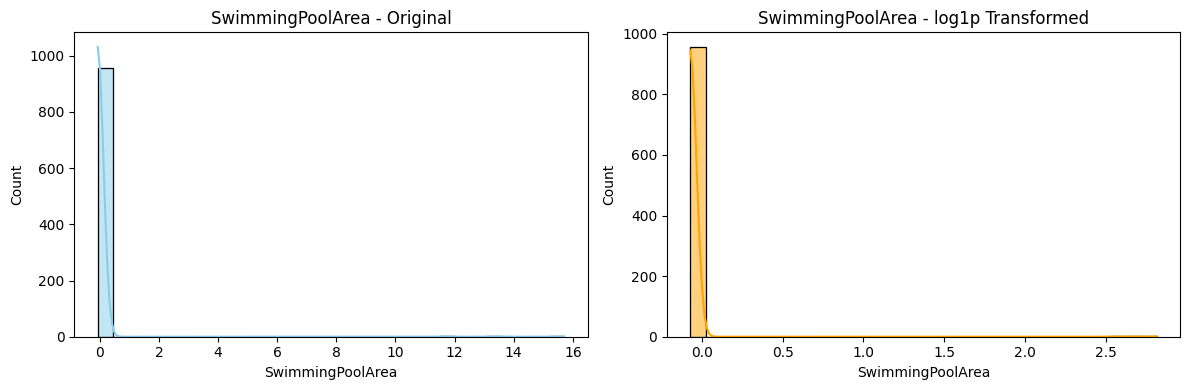

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


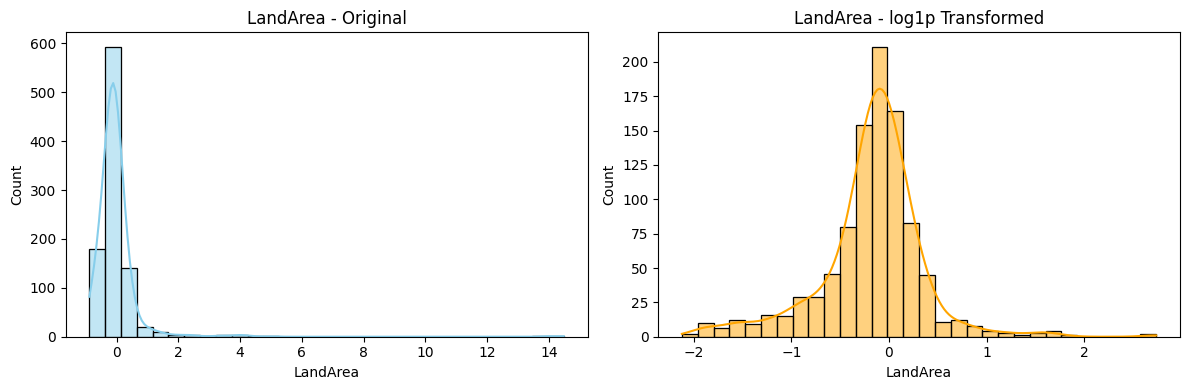

In [4]:
# === Skewness before and after log1p ===
skew_before = X_train[num_cols].skew()
X_train_log = X_train.copy()
for col in skewed_cols:
    X_train_log[col] = np.log1p(X_train_log[col])
skew_after = X_train_log[num_cols].skew()

plt.figure(figsize=(14,6))
x = np.arange(len(num_cols))
width = 0.35
plt.bar(x - width/2, skew_before.values, width, label='Before log', color='skyblue')
plt.bar(x + width/2, skew_after.values, width, label='After log', color='orange', alpha=0.7)
plt.xticks(x, skew_before.index, rotation=90)
plt.ylabel('Skewness')
plt.title('Feature Skewness Before and After log1p Transform')
plt.legend()
plt.tight_layout()
plt.show()

# === Distribution plots for top 3 skewed features ===
top_skewed = skew_before.sort_values(ascending=False).head(3).index.tolist()
for col in top_skewed:
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    sns.histplot(X_train[col], bins=30, kde=True, color='skyblue')
    plt.title(f'{col} - Original')
    
    plt.subplot(1,2,2)
    sns.histplot(np.log1p(X_train[col]), bins=30, kde=True, color='orange')
    plt.title(f'{col} - log1p Transformed')
    
    plt.tight_layout()
    plt.show()

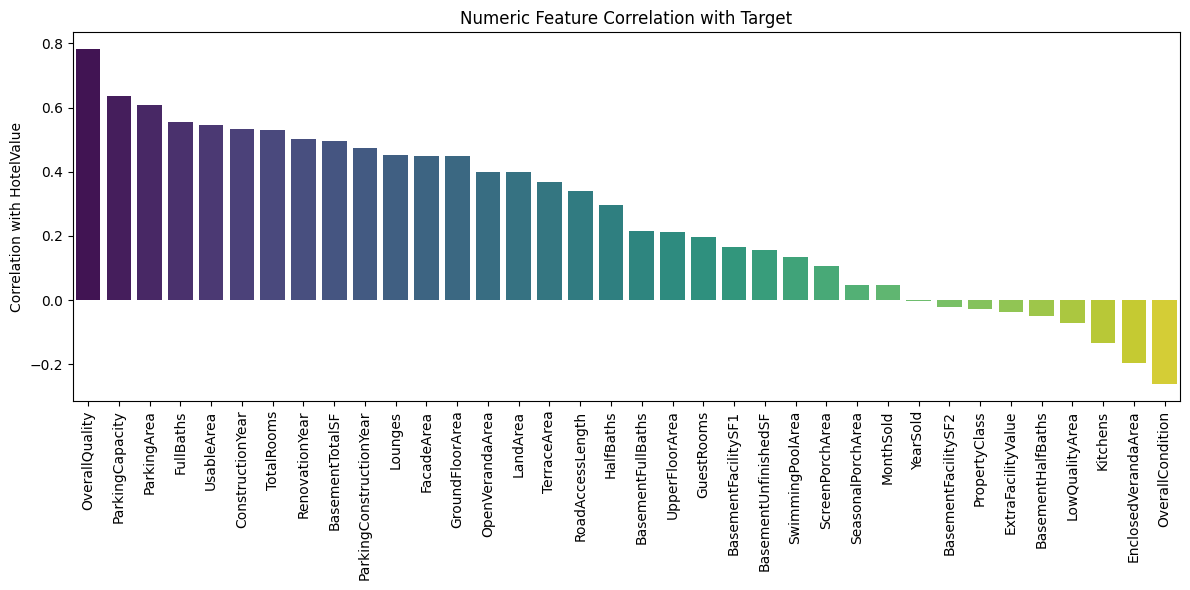

In [5]:
# === Correlation with target ===
corr_with_target = X_train_log[num_cols].join(y_train).corr()[TARGET].drop(TARGET).sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=corr_with_target.index, y=corr_with_target.values, palette='viridis')
plt.xticks(rotation=90)
plt.ylabel('Correlation with HotelValue')
plt.title('Numeric Feature Correlation with Target')
plt.tight_layout()
plt.show()

In [6]:
# === Numeric preprocessing ===

def safe_log1p(X):
    X = np.where(X < 0, 0, X)  # clip negatives to 0
    return np.log1p(X)

numeric_transformer = ColumnTransformer([
    ("skewed", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("log", FunctionTransformer(safe_log1p, validate=False)),
        ("scaler", StandardScaler())
    ]), skewed_cols),
    ("non_skewed", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), non_skewed_cols)
])

# === Full preprocessing including categorical features ===
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

In [7]:
# === KNN model with log-target transform ===
knn = KNeighborsRegressor()
knn_model = TransformedTargetRegressor(
    regressor=knn,
    func=np.log1p,
    inverse_func=np.expm1
)

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", knn_model)
])

# === Hyperparameter grid ===
param_grid = {
    "model__regressor__n_neighbors": [3, 5, 7, 9, 11],
    "model__regressor__weights": ["uniform", "distance"],
    "model__regressor__p": [1, 2]
}

grid_knn = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

In [8]:
# === Train ===
grid_knn.fit(X_train, y_train)

print("Best Parameters:", grid_knn.best_params_)
print("Best CV RMSE (log-space):", -grid_knn.best_score_)

# === Evaluate on train/validation set ===
y_pred_train = grid_knn.predict(X_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)

y_pred_valid = grid_knn.predict(X_valid)
val_rmse = mean_squared_error(y_valid, y_pred_valid, squared=False)

print(f"Training RMSE (original scale): {train_rmse:.2f}")
print(f"Validation RMSE (original scale): {val_rmse:.2f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'model__regressor__n_neighbors': 5, 'model__regressor__p': 1, 'model__regressor__weights': 'distance'}
Best CV RMSE (log-space): 35068.31578448445
Training RMSE (original scale): 0.00
Validation RMSE (original scale): 38607.50


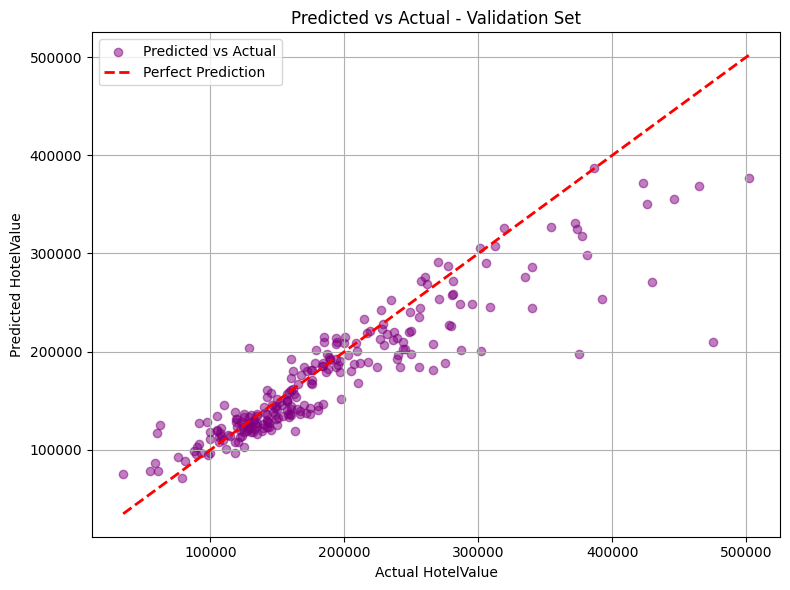

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


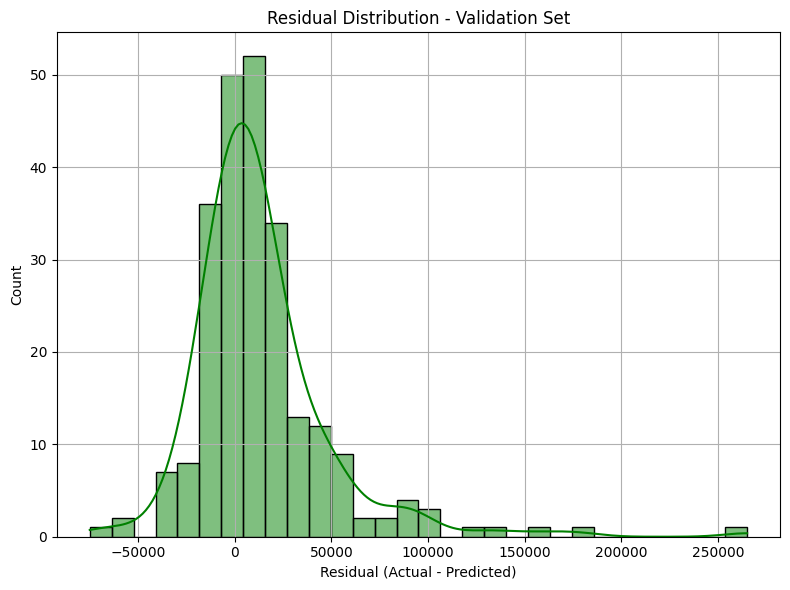

In [9]:
# === Predicted vs Actual plot (Validation Set) ===
plt.figure(figsize=(8,6))
plt.scatter(y_valid, y_pred_valid, alpha=0.5, color='purple', label='Predicted vs Actual')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual HotelValue")
plt.ylabel("Predicted HotelValue")
plt.title("Predicted vs Actual - Validation Set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Residual plot ===
residuals = y_valid - y_pred_valid
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True, color='green')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.title("Residual Distribution - Validation Set")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# === Predict on test set ===
test_preds = grid_knn.predict(test[features])

# === Create submission ===
submission = pd.DataFrame({
    "Id": test["Id"],
    "HotelValue": test_preds
})
submission.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' created successfully!")

Submission file 'submission.csv' created successfully!
